# Step 3: Model Development
## Loan Approval Prediction Using Classical and Modern Machine Learning Techniques

**Objective:** Apply classical ML techniques (Logistic Regression, Regularization, PCA, Cross-validation) and modern ML techniques (SVM, Random Forest, XGBoost, Neural Networks) to predict loan approval.

---

### Notebook Structure
1. **Setup and Data Preparation**
2. **Logistic Regression (Baseline)**
3. **Regularization (L1/L2/ElasticNet)**
4. **PCA Analysis**
5. **Cross-Validation**
6. **Support Vector Machines**
7. **Random Forest**
8. **XGBoost**
9. **Neural Network (MLP)**
10. **Model Comparison**
11. **Feature Importance Analysis**
12. **Conclusions**

---
## Section 1: Setup and Data Preparation

Load the preprocessed dataset and prepare features for modeling.

In [1]:
# ============================================
# 1.1 Import Required Libraries
# ============================================

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Classical ML Models
from sklearn.linear_model import LogisticRegression

# Modern ML Models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Neural Network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Evaluation Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

print("All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

All libraries imported successfully!
TensorFlow version: 2.20.0


In [2]:
# ============================================
# 1.2 Load Preprocessed Dataset
# ============================================

# Load the preprocessed data from Step 2
df = pd.read_csv('data/loan_approval_dataset_preprocessed.csv')

print("Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")

Dataset loaded successfully!
Dataset shape: (4269, 22)

Columns: ['loan_id', 'no_of_dependents', 'education', 'self_employed', 'income_annum', 'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value', 'loan_status', 'education_encoded', 'self_employed_encoded', 'loan_status_encoded', 'total_assets_value', 'loan_to_income_ratio', 'assets_to_loan_ratio', 'monthly_income', 'monthly_loan_payment', 'debt_to_income_ratio']


In [3]:
# ============================================
# 1.3 Define Features and Target
# ============================================

# Features to use for modeling (17 features)
feature_columns = [
    'no_of_dependents',
    'income_annum',
    'loan_amount',
    'loan_term',
    'cibil_score',
    'residential_assets_value',
    'commercial_assets_value',
    'luxury_assets_value',
    'bank_asset_value',
    'education_encoded',
    'self_employed_encoded',
    'total_assets_value',
    'loan_to_income_ratio',
    'assets_to_loan_ratio',
    'monthly_income',
    'monthly_loan_payment',
    'debt_to_income_ratio'
]

# Define X (features) and y (target)
X = df[feature_columns]
y = df['loan_status_encoded']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nTarget distribution:")
print(y.value_counts())
print(f"\nClass balance: {y.value_counts(normalize=True).round(3)}")

Features shape: (4269, 17)
Target shape: (4269,)

Target distribution:
loan_status_encoded
0    2656
1    1613
Name: count, dtype: int64

Class balance: loan_status_encoded
0    0.622
1    0.378
Name: proportion, dtype: float64


In [4]:
# ============================================
# 1.4 Train-Test Split
# ============================================

# Split data with stratification to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=RANDOM_STATE, 
    stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTraining set class distribution:")
print(y_train.value_counts())
print(f"\nTest set class distribution:")
print(y_test.value_counts())

Training set: 3415 samples
Test set: 854 samples

Training set class distribution:
loan_status_encoded
0    2125
1    1290
Name: count, dtype: int64

Test set class distribution:
loan_status_encoded
0    531
1    323
Name: count, dtype: int64


In [5]:
# ============================================
# 1.5 Feature Scaling
# ============================================

# Scale features (required for SVM and Neural Networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to DataFrame for easier handling
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_columns)

print("Feature scaling completed!")
print(f"\nScaled features mean (should be ~0): {X_train_scaled.mean(axis=0).round(2)[:5]}...")
print(f"Scaled features std (should be ~1): {X_train_scaled.std(axis=0).round(2)[:5]}...")

Feature scaling completed!

Scaled features mean (should be ~0): [ 0. -0.  0. -0. -0.]...
Scaled features std (should be ~1): [1. 1. 1. 1. 1.]...


In [6]:
# ============================================
# 1.6 Calculate Class Weights
# ============================================

# Calculate class weights for handling imbalance
n_rejected = (y_train == 1).sum()  # Class 1 is rejected
n_approved = (y_train == 0).sum()  # Class 0 is approved

# For XGBoost scale_pos_weight
scale_pos_weight = n_rejected / n_approved

print(f"Class 0 (Approved): {n_approved} samples")
print(f"Class 1 (Rejected): {n_rejected} samples")
print(f"Scale pos weight for XGBoost: {scale_pos_weight:.2f}")

Class 0 (Approved): 2125 samples
Class 1 (Rejected): 1290 samples
Scale pos weight for XGBoost: 0.61


In [7]:
# ============================================
# 1.7 Initialize Results Storage
# ============================================

# Dictionary to store all model results
results = {}

def evaluate_model(model_name, y_true, y_pred, y_prob=None):
    """Evaluate model and store results"""
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    if y_prob is not None:
        roc_auc = roc_auc_score(y_true, y_prob)
    else:
        roc_auc = None
    
    results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    }
    
    print(f"\n{'='*50}")
    print(f"{model_name} Results")
    print(f"{'='*50}")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    if roc_auc:
        print(f"ROC-AUC:   {roc_auc:.4f}")
    
    return results[model_name]

print("Setup complete! Ready for model training.")

Setup complete! Ready for model training.


---
## Section 2: Logistic Regression (Baseline)

**Classical ML Technique #1**

Logistic Regression serves as our baseline model. It's interpretable, fast, and provides coefficients that indicate feature importance.

In [8]:
# ============================================
# 2.1 Train Logistic Regression (Baseline)
# ============================================

# Train logistic regression with balanced class weights
lr_baseline = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=RANDOM_STATE
)

lr_baseline.fit(X_train_scaled, y_train)

# Predictions
y_pred_lr = lr_baseline.predict(X_test_scaled)
y_prob_lr = lr_baseline.predict_proba(X_test_scaled)[:, 1]

# Evaluate
evaluate_model('Logistic Regression (Baseline)', y_test, y_pred_lr, y_prob_lr)

# Confusion Matrix
print(f"\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['Approved', 'Rejected']))


Logistic Regression (Baseline) Results
Accuracy:  0.9450
Precision: 0.9182
Recall:    0.9381
F1-Score:  0.9280
ROC-AUC:   0.9778

Confusion Matrix:
[[504  27]
 [ 20 303]]

Classification Report:
              precision    recall  f1-score   support

    Approved       0.96      0.95      0.96       531
    Rejected       0.92      0.94      0.93       323

    accuracy                           0.94       854
   macro avg       0.94      0.94      0.94       854
weighted avg       0.95      0.94      0.95       854



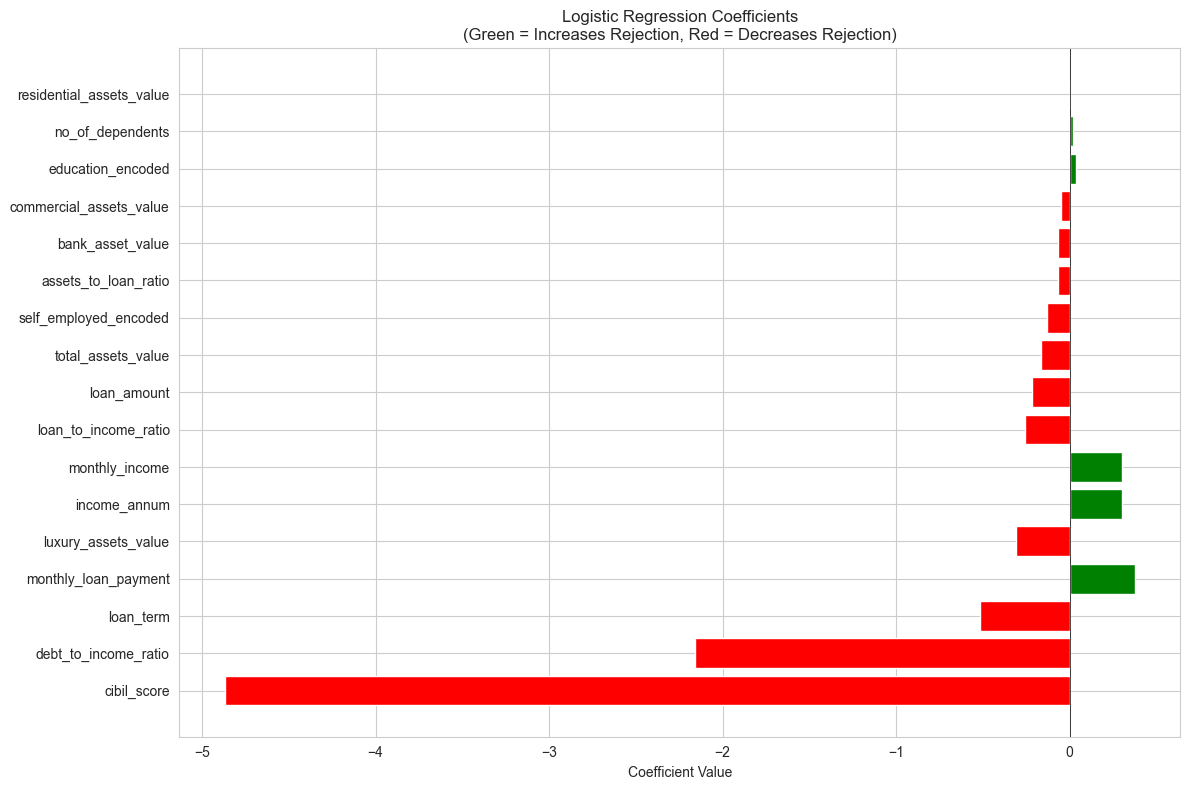


Top 5 Most Important Features (by coefficient magnitude):
                 Feature  Coefficient  Abs_Coefficient
4            cibil_score    -4.868075         4.868075
16  debt_to_income_ratio    -2.159081         2.159081
3              loan_term    -0.517309         0.517309
15  monthly_loan_payment     0.374238         0.374238
7    luxury_assets_value    -0.307597         0.307597


In [9]:
# ============================================
# 2.2 Feature Coefficients Analysis
# ============================================

# Get coefficients and sort by absolute value
coefficients = pd.DataFrame({
    'Feature': feature_columns,
    'Coefficient': lr_baseline.coef_[0]
})
coefficients['Abs_Coefficient'] = np.abs(coefficients['Coefficient'])
coefficients = coefficients.sort_values('Abs_Coefficient', ascending=False)

# Plot coefficients
plt.figure(figsize=(12, 8))
colors = ['green' if c > 0 else 'red' for c in coefficients['Coefficient']]
plt.barh(range(len(coefficients)), coefficients['Coefficient'], color=colors)
plt.yticks(range(len(coefficients)), coefficients['Feature'])
plt.xlabel('Coefficient Value')
plt.title('Logistic Regression Coefficients\n(Green = Increases Rejection, Red = Decreases Rejection)')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.savefig('presentation_images/lr_coefficients.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nTop 5 Most Important Features (by coefficient magnitude):")
print(coefficients.head())

---
## Section 3: Regularization (L1/L2/ElasticNet)

**Classical ML Technique #2**

Regularization helps prevent overfitting:
- **L1 (Lasso)**: Promotes sparsity, performs feature selection
- **L2 (Ridge)**: Handles multicollinearity, shrinks coefficients
- **ElasticNet**: Combines L1 and L2 benefits

In [10]:
# ============================================
# 3.1 L1 Regularization (Lasso)
# ============================================

lr_l1 = LogisticRegression(
    penalty='l1',
    solver='saga',
    class_weight='balanced',
    max_iter=2000,
    random_state=RANDOM_STATE
)

lr_l1.fit(X_train_scaled, y_train)

# Predictions
y_pred_l1 = lr_l1.predict(X_test_scaled)
y_prob_l1 = lr_l1.predict_proba(X_test_scaled)[:, 1]

# Evaluate
evaluate_model('Logistic Regression (L1)', y_test, y_pred_l1, y_prob_l1)

# Check which features were zeroed out
l1_coef = pd.DataFrame({
    'Feature': feature_columns,
    'L1_Coefficient': lr_l1.coef_[0]
})
zeroed_features = l1_coef[l1_coef['L1_Coefficient'] == 0]['Feature'].tolist()
print(f"\nFeatures zeroed out by L1: {len(zeroed_features)}")
if zeroed_features:
    print(f"Features: {zeroed_features}")


Logistic Regression (L1) Results
Accuracy:  0.9450
Precision: 0.9182
Recall:    0.9381
F1-Score:  0.9280
ROC-AUC:   0.9778

Features zeroed out by L1: 1
Features: ['residential_assets_value']


In [11]:
# ============================================
# 3.2 L2 Regularization (Ridge)
# ============================================

lr_l2 = LogisticRegression(
    penalty='l2',
    class_weight='balanced',
    max_iter=1000,
    random_state=RANDOM_STATE
)

lr_l2.fit(X_train_scaled, y_train)

# Predictions
y_pred_l2 = lr_l2.predict(X_test_scaled)
y_prob_l2 = lr_l2.predict_proba(X_test_scaled)[:, 1]

# Evaluate
evaluate_model('Logistic Regression (L2)', y_test, y_pred_l2, y_prob_l2)


Logistic Regression (L2) Results
Accuracy:  0.9450
Precision: 0.9182
Recall:    0.9381
F1-Score:  0.9280
ROC-AUC:   0.9778


{'Accuracy': 0.9449648711943794,
 'Precision': 0.9181818181818182,
 'Recall': 0.9380804953560371,
 'F1-Score': 0.9280245022970903,
 'ROC-AUC': 0.9777801099625102}

In [12]:
# ============================================
# 3.3 ElasticNet Regularization
# ============================================

lr_elasticnet = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    l1_ratio=0.5,  # 50% L1, 50% L2
    class_weight='balanced',
    max_iter=2000,
    random_state=RANDOM_STATE
)

lr_elasticnet.fit(X_train_scaled, y_train)

# Predictions
y_pred_en = lr_elasticnet.predict(X_test_scaled)
y_prob_en = lr_elasticnet.predict_proba(X_test_scaled)[:, 1]

# Evaluate
evaluate_model('Logistic Regression (ElasticNet)', y_test, y_pred_en, y_prob_en)


Logistic Regression (ElasticNet) Results
Accuracy:  0.9450
Precision: 0.9182
Recall:    0.9381
F1-Score:  0.9280
ROC-AUC:   0.9777


{'Accuracy': 0.9449648711943794,
 'Precision': 0.9181818181818182,
 'Recall': 0.9380804953560371,
 'F1-Score': 0.9280245022970903,
 'ROC-AUC': 0.9777451271915248}

Coefficient Comparison Across Regularization Methods:
                     Feature  Baseline  L1 (Lasso)  L2 (Ridge)  ElasticNet
0           no_of_dependents    0.0200      0.0147      0.0200      0.0173
1               income_annum    0.3024      0.1987      0.3024      0.2731
2                loan_amount   -0.2172     -0.0714     -0.2172     -0.1636
3                  loan_term   -0.5173     -0.5411     -0.5173     -0.5289
4                cibil_score   -4.8681     -5.0344     -4.8681     -4.9534
5   residential_assets_value    0.0025      0.0000      0.0025      0.0000
6    commercial_assets_value   -0.0509     -0.0444     -0.0509     -0.0481
7        luxury_assets_value   -0.3076     -0.2983     -0.3076     -0.3121
8           bank_asset_value   -0.0658     -0.0496     -0.0658     -0.0604
9          education_encoded    0.0377      0.0341      0.0377      0.0357
10     self_employed_encoded   -0.1290     -0.1291     -0.1290     -0.1289
11        total_assets_value   -0.1660     -0.

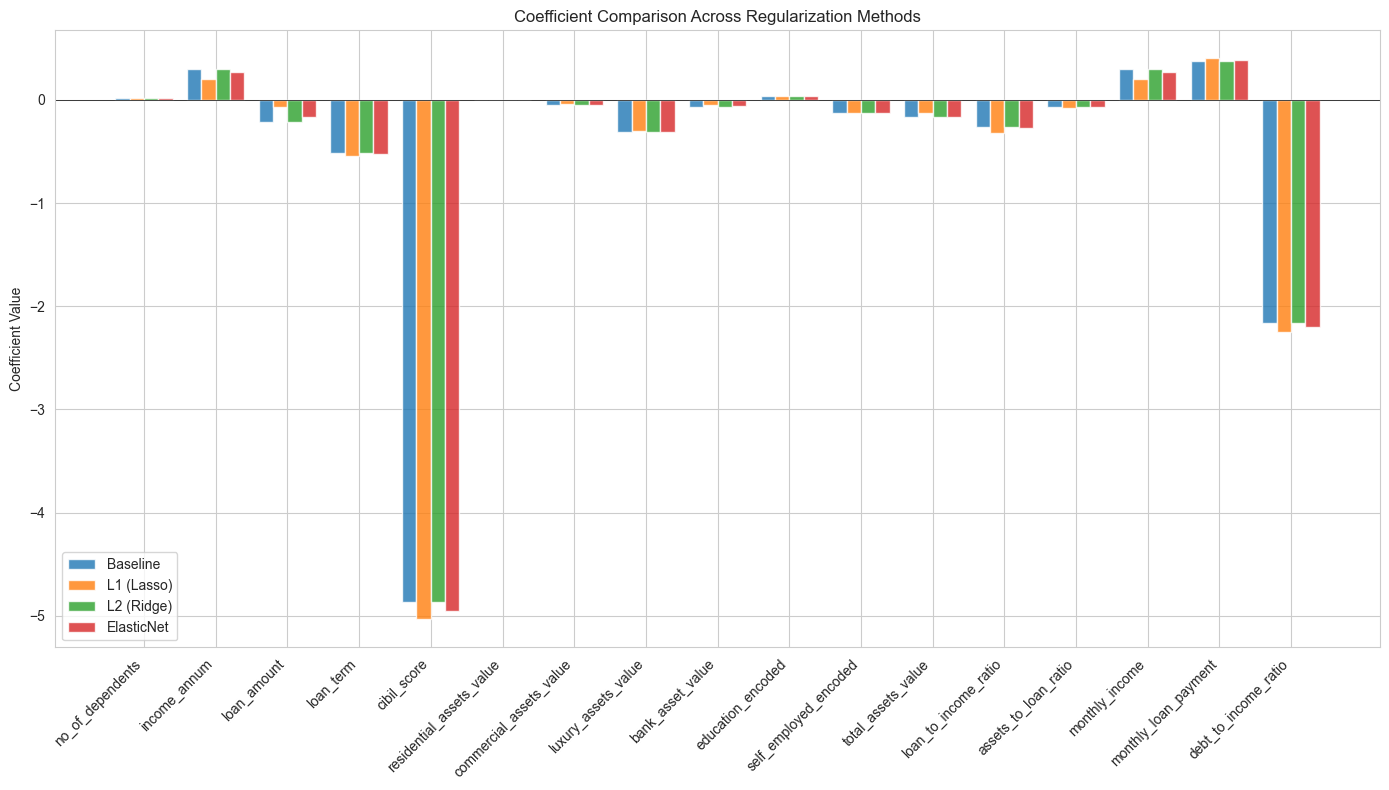

In [13]:
# ============================================
# 3.4 Compare Regularization Methods
# ============================================

# Compare coefficients across regularization methods
reg_comparison = pd.DataFrame({
    'Feature': feature_columns,
    'Baseline': lr_baseline.coef_[0],
    'L1 (Lasso)': lr_l1.coef_[0],
    'L2 (Ridge)': lr_l2.coef_[0],
    'ElasticNet': lr_elasticnet.coef_[0]
})

print("Coefficient Comparison Across Regularization Methods:")
print(reg_comparison.round(4))

# Visualize coefficient comparison
fig, ax = plt.subplots(figsize=(14, 8))
x = np.arange(len(feature_columns))
width = 0.2

ax.bar(x - 1.5*width, reg_comparison['Baseline'], width, label='Baseline', alpha=0.8)
ax.bar(x - 0.5*width, reg_comparison['L1 (Lasso)'], width, label='L1 (Lasso)', alpha=0.8)
ax.bar(x + 0.5*width, reg_comparison['L2 (Ridge)'], width, label='L2 (Ridge)', alpha=0.8)
ax.bar(x + 1.5*width, reg_comparison['ElasticNet'], width, label='ElasticNet', alpha=0.8)

ax.set_ylabel('Coefficient Value')
ax.set_title('Coefficient Comparison Across Regularization Methods')
ax.set_xticks(x)
ax.set_xticklabels(feature_columns, rotation=45, ha='right')
ax.legend()
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.savefig('presentation_images/regularization_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

---
## Section 4: PCA Analysis

**Classical ML Technique #3**

Principal Component Analysis (PCA) reduces dimensionality while preserving variance. We'll analyze how many components are needed and compare model performance with/without PCA.

In [14]:
# ============================================
# 4.1 Fit PCA and Analyze Variance
# ============================================

# Fit PCA on all components
pca_full = PCA(random_state=RANDOM_STATE)
pca_full.fit(X_train_scaled)

# Explained variance ratio
explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Find number of components for 95% variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

print(f"Number of components for 95% variance: {n_components_95}")
print(f"\nExplained Variance Ratio (first 10 components):")
for i, (var, cum) in enumerate(zip(explained_variance[:10], cumulative_variance[:10])):
    print(f"  PC{i+1}: {var:.4f} (Cumulative: {cum:.4f})")

Number of components for 95% variance: 10

Explained Variance Ratio (first 10 components):
  PC1: 0.3930 (Cumulative: 0.3930)
  PC2: 0.1449 (Cumulative: 0.5378)
  PC3: 0.1038 (Cumulative: 0.6416)
  PC4: 0.0605 (Cumulative: 0.7021)
  PC5: 0.0595 (Cumulative: 0.7616)
  PC6: 0.0587 (Cumulative: 0.8203)
  PC7: 0.0567 (Cumulative: 0.8769)
  PC8: 0.0371 (Cumulative: 0.9140)
  PC9: 0.0335 (Cumulative: 0.9475)
  PC10: 0.0167 (Cumulative: 0.9642)


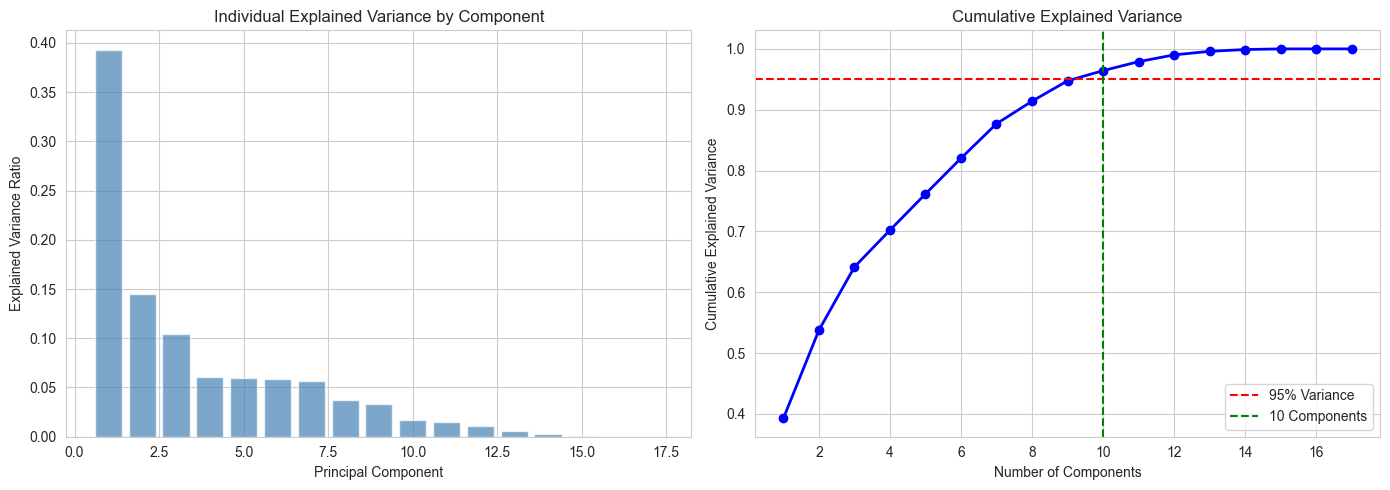

In [15]:
# ============================================
# 4.2 Visualize Explained Variance
# ============================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Individual explained variance
axes[0].bar(range(1, len(explained_variance)+1), explained_variance, alpha=0.7, color='steelblue')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('Individual Explained Variance by Component')

# Cumulative explained variance
axes[1].plot(range(1, len(cumulative_variance)+1), cumulative_variance, 'bo-', linewidth=2)
axes[1].axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
axes[1].axvline(x=n_components_95, color='g', linestyle='--', label=f'{n_components_95} Components')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title('Cumulative Explained Variance')
axes[1].legend()

plt.tight_layout()
plt.savefig('presentation_images/pca_variance.png', dpi=150, bbox_inches='tight')
plt.show()

In [16]:
# ============================================
# 4.3 Train Logistic Regression with PCA
# ============================================

# Apply PCA with n_components for 95% variance
pca = PCA(n_components=n_components_95, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Original features: {X_train_scaled.shape[1]}")
print(f"PCA features: {X_train_pca.shape[1]}")
print(f"Dimensionality reduction: {(1 - X_train_pca.shape[1]/X_train_scaled.shape[1])*100:.1f}%")

# Train Logistic Regression on PCA features
lr_pca = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=RANDOM_STATE
)

lr_pca.fit(X_train_pca, y_train)

# Predictions
y_pred_pca = lr_pca.predict(X_test_pca)
y_prob_pca = lr_pca.predict_proba(X_test_pca)[:, 1]

# Evaluate
evaluate_model('Logistic Regression (PCA)', y_test, y_pred_pca, y_prob_pca)

Original features: 17
PCA features: 10
Dimensionality reduction: 41.2%

Logistic Regression (PCA) Results
Accuracy:  0.9450
Precision: 0.9233
Recall:    0.9319
F1-Score:  0.9276
ROC-AUC:   0.9780


{'Accuracy': 0.9449648711943794,
 'Precision': 0.9233128834355828,
 'Recall': 0.9318885448916409,
 'F1-Score': 0.9275808936825886,
 'ROC-AUC': 0.9780249893594072}

In [17]:
# ============================================
# 4.4 Compare With/Without PCA
# ============================================

comparison_data = {
    'Model': ['Without PCA', 'With PCA'],
    'Features': [17, n_components_95],
    'Accuracy': [results['Logistic Regression (Baseline)']['Accuracy'], 
                 results['Logistic Regression (PCA)']['Accuracy']],
    'F1-Score': [results['Logistic Regression (Baseline)']['F1-Score'], 
                 results['Logistic Regression (PCA)']['F1-Score']],
    'ROC-AUC': [results['Logistic Regression (Baseline)']['ROC-AUC'], 
               results['Logistic Regression (PCA)']['ROC-AUC']]
}

pca_comparison = pd.DataFrame(comparison_data)
print("\nPCA Comparison:")
print(pca_comparison.to_string(index=False))


PCA Comparison:
      Model  Features  Accuracy  F1-Score  ROC-AUC
Without PCA        17  0.944965  0.928025 0.977780
   With PCA        10  0.944965  0.927581 0.978025


---
## Section 5: Cross-Validation

**Classical ML Technique #4**

K-Fold Cross-Validation provides more reliable performance estimates. We use Stratified K-Fold to maintain class distribution in each fold.

In [18]:
# ============================================
# 5.1 Setup Cross-Validation
# ============================================

# Define Stratified K-Fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Models to cross-validate
cv_models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=RANDOM_STATE),
    'LR with L1': LogisticRegression(penalty='l1', solver='saga', class_weight='balanced', max_iter=2000, random_state=RANDOM_STATE),
    'LR with L2': LogisticRegression(penalty='l2', class_weight='balanced', max_iter=1000, random_state=RANDOM_STATE),
    'LR with ElasticNet': LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, class_weight='balanced', max_iter=2000, random_state=RANDOM_STATE)
}

print(f"Cross-Validation Setup:")
print(f"  - K-Folds: 5")
print(f"  - Stratified: Yes")
print(f"  - Models: {list(cv_models.keys())}")

Cross-Validation Setup:
  - K-Folds: 5
  - Stratified: Yes
  - Models: ['Logistic Regression', 'LR with L1', 'LR with L2', 'LR with ElasticNet']


In [19]:
# ============================================
# 5.2 Perform Cross-Validation
# ============================================

cv_results = {}

for model_name, model in cv_models.items():
    # Cross-validate for accuracy
    accuracy_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy')
    # Cross-validate for F1
    f1_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='f1')
    # Cross-validate for ROC-AUC
    roc_auc_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='roc_auc')
    
    cv_results[model_name] = {
        'Accuracy': f"{accuracy_scores.mean():.4f} ± {accuracy_scores.std():.4f}",
        'F1-Score': f"{f1_scores.mean():.4f} ± {f1_scores.std():.4f}",
        'ROC-AUC': f"{roc_auc_scores.mean():.4f} ± {roc_auc_scores.std():.4f}",
        'Accuracy_mean': accuracy_scores.mean(),
        'F1_mean': f1_scores.mean(),
        'ROC_AUC_mean': roc_auc_scores.mean()
    }
    
    print(f"\n{model_name}:")
    print(f"  Accuracy: {cv_results[model_name]['Accuracy']}")
    print(f"  F1-Score: {cv_results[model_name]['F1-Score']}")
    print(f"  ROC-AUC:  {cv_results[model_name]['ROC-AUC']}")


Logistic Regression:
  Accuracy: 0.9347 ± 0.0070
  F1-Score: 0.9164 ± 0.0088
  ROC-AUC:  0.9768 ± 0.0020

LR with L1:
  Accuracy: 0.9341 ± 0.0063
  F1-Score: 0.9156 ± 0.0081
  ROC-AUC:  0.9768 ± 0.0019

LR with L2:
  Accuracy: 0.9347 ± 0.0070
  F1-Score: 0.9164 ± 0.0088
  ROC-AUC:  0.9768 ± 0.0020

LR with ElasticNet:
  Accuracy: 0.9353 ± 0.0073
  F1-Score: 0.9171 ± 0.0092
  ROC-AUC:  0.9768 ± 0.0019


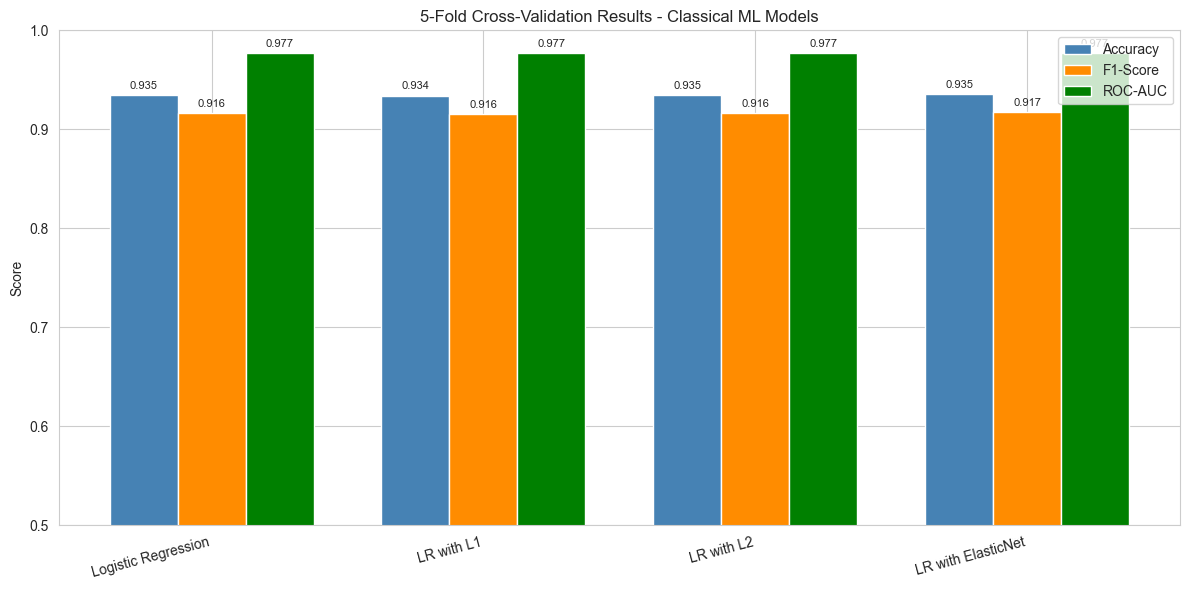

In [20]:
# ============================================
# 5.3 Visualize Cross-Validation Results
# ============================================

# Prepare data for plotting
model_names = list(cv_results.keys())
accuracy_means = [cv_results[m]['Accuracy_mean'] for m in model_names]
f1_means = [cv_results[m]['F1_mean'] for m in model_names]
roc_auc_means = [cv_results[m]['ROC_AUC_mean'] for m in model_names]

x = np.arange(len(model_names))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width, accuracy_means, width, label='Accuracy', color='steelblue')
bars2 = ax.bar(x, f1_means, width, label='F1-Score', color='darkorange')
bars3 = ax.bar(x + width, roc_auc_means, width, label='ROC-AUC', color='green')

ax.set_ylabel('Score')
ax.set_title('5-Fold Cross-Validation Results - Classical ML Models')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=15, ha='right')
ax.legend()
ax.set_ylim(0.5, 1.0)

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('presentation_images/cv_results_classical.png', dpi=150, bbox_inches='tight')
plt.show()

---
## Section 6: Support Vector Machines

**Modern ML Technique #1**

SVM finds the optimal hyperplane to separate classes. We'll compare different kernels:
- **Linear**: Linear decision boundary
- **RBF**: Non-linear, handles complex patterns
- **Polynomial**: Non-linear with polynomial features

In [21]:
# ============================================
# 6.1 SVM with Linear Kernel
# ============================================

svm_linear = SVC(
    kernel='linear',
    class_weight='balanced',
    probability=True,
    random_state=RANDOM_STATE
)

svm_linear.fit(X_train_scaled, y_train)

# Predictions
y_pred_svm_linear = svm_linear.predict(X_test_scaled)
y_prob_svm_linear = svm_linear.predict_proba(X_test_scaled)[:, 1]

# Evaluate
evaluate_model('SVM (Linear)', y_test, y_pred_svm_linear, y_prob_svm_linear)


SVM (Linear) Results
Accuracy:  0.9485
Precision: 0.9189
Recall:    0.9474
F1-Score:  0.9329
ROC-AUC:   0.9779


{'Accuracy': 0.9484777517564403,
 'Precision': 0.918918918918919,
 'Recall': 0.9473684210526315,
 'F1-Score': 0.9329268292682927,
 'ROC-AUC': 0.9779142105846204}

In [22]:
# ============================================
# 6.2 SVM with RBF Kernel
# ============================================

svm_rbf = SVC(
    kernel='rbf',
    class_weight='balanced',
    probability=True,
    random_state=RANDOM_STATE
)

svm_rbf.fit(X_train_scaled, y_train)

# Predictions
y_pred_svm_rbf = svm_rbf.predict(X_test_scaled)
y_prob_svm_rbf = svm_rbf.predict_proba(X_test_scaled)[:, 1]

# Evaluate
evaluate_model('SVM (RBF)', y_test, y_pred_svm_rbf, y_prob_svm_rbf)


SVM (RBF) Results
Accuracy:  0.9555
Precision: 0.9385
Recall:    0.9443
F1-Score:  0.9414
ROC-AUC:   0.9877


{'Accuracy': 0.955503512880562,
 'Precision': 0.9384615384615385,
 'Recall': 0.9442724458204335,
 'F1-Score': 0.941358024691358,
 'ROC-AUC': 0.9876744036895163}

In [23]:
# ============================================
# 6.3 SVM with Polynomial Kernel
# ============================================

svm_poly = SVC(
    kernel='poly',
    degree=3,
    class_weight='balanced',
    probability=True,
    random_state=RANDOM_STATE
)

svm_poly.fit(X_train_scaled, y_train)

# Predictions
y_pred_svm_poly = svm_poly.predict(X_test_scaled)
y_prob_svm_poly = svm_poly.predict_proba(X_test_scaled)[:, 1]

# Evaluate
evaluate_model('SVM (Polynomial)', y_test, y_pred_svm_poly, y_prob_svm_poly)


SVM (Polynomial) Results
Accuracy:  0.9473
Precision: 0.9162
Recall:    0.9474
F1-Score:  0.9315
ROC-AUC:   0.9816


{'Accuracy': 0.9473067915690867,
 'Precision': 0.9161676646706587,
 'Recall': 0.9473684210526315,
 'F1-Score': 0.9315068493150684,
 'ROC-AUC': 0.9816457061563846}

In [24]:
# ============================================
# 6.4 SVM Hyperparameter Tuning (RBF)
# ============================================

# GridSearchCV for RBF kernel
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto', 0.1, 1]
}

svm_grid = GridSearchCV(
    SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=RANDOM_STATE),
    param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1
)

svm_grid.fit(X_train_scaled, y_train)

print(f"Best Parameters: {svm_grid.best_params_}")
print(f"Best CV F1-Score: {svm_grid.best_score_:.4f}")

# Evaluate best model
y_pred_svm_best = svm_grid.predict(X_test_scaled)
y_prob_svm_best = svm_grid.predict_proba(X_test_scaled)[:, 1]

evaluate_model('SVM (Tuned RBF)', y_test, y_pred_svm_best, y_prob_svm_best)

Best Parameters: {'C': 10, 'gamma': 'scale'}
Best CV F1-Score: 0.9335

SVM (Tuned RBF) Results
Accuracy:  0.9578
Precision: 0.9556
Recall:    0.9319
F1-Score:  0.9436
ROC-AUC:   0.9913


{'Accuracy': 0.9578454332552693,
 'Precision': 0.9555555555555556,
 'Recall': 0.9318885448916409,
 'F1-Score': 0.9435736677115988,
 'ROC-AUC': 0.9913475946429716}

---
## Section 7: Random Forest

**Modern ML Technique #2**

Random Forest is an ensemble method that builds multiple decision trees and combines their predictions. It provides:
- Robust predictions through averaging
- Built-in feature importance
- Resistance to overfitting

In [25]:
# ============================================
# 7.1 Train Random Forest
# ============================================

rf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf.fit(X_train_scaled, y_train)

# Predictions
y_pred_rf = rf.predict(X_test_scaled)
y_prob_rf = rf.predict_proba(X_test_scaled)[:, 1]

# Evaluate
evaluate_model('Random Forest', y_test, y_pred_rf, y_prob_rf)

# Confusion Matrix
print(f"\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))


Random Forest Results
Accuracy:  0.9988
Precision: 1.0000
Recall:    0.9969
F1-Score:  0.9984
ROC-AUC:   1.0000

Confusion Matrix:
[[531   0]
 [  1 322]]


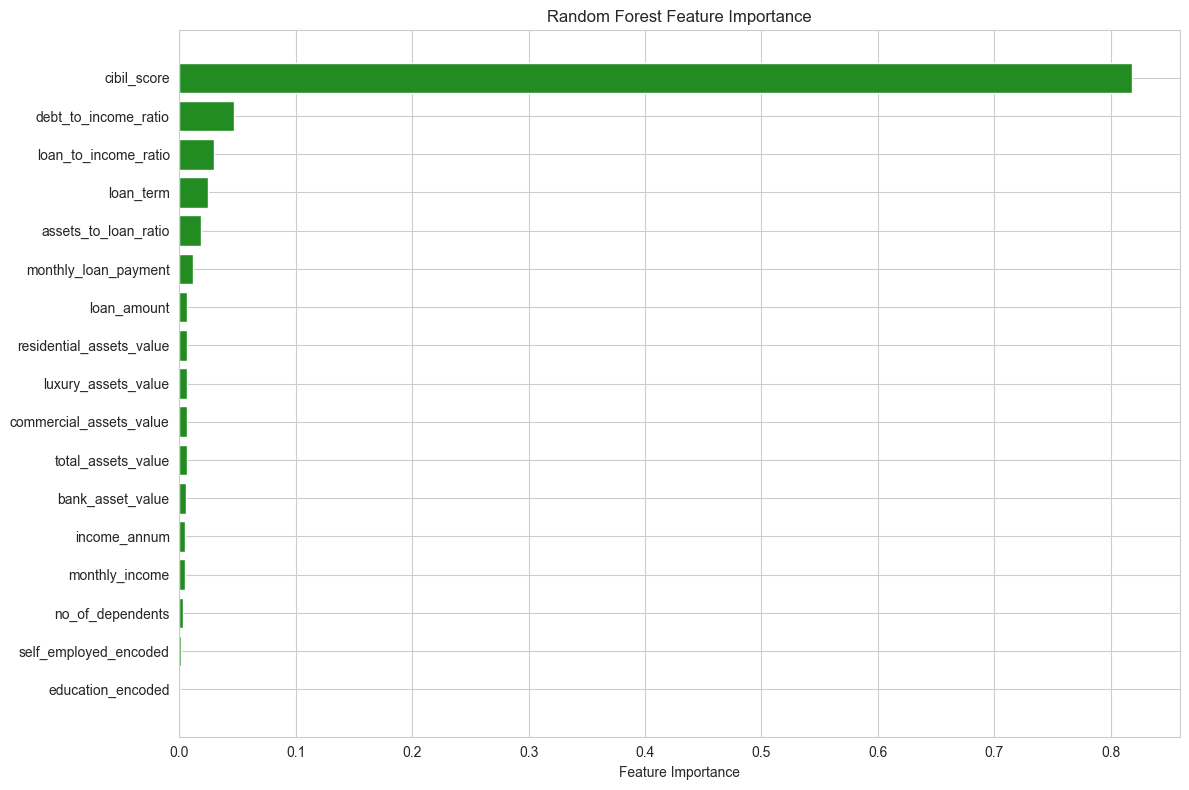


Top 5 Most Important Features (Random Forest):
                 Feature  Importance
4            cibil_score    0.818677
16  debt_to_income_ratio    0.046531
12  loan_to_income_ratio    0.029908
3              loan_term    0.024296
13  assets_to_loan_ratio    0.018852


In [26]:
# ============================================
# 7.2 Random Forest Feature Importance
# ============================================

# Get feature importance
rf_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.barh(range(len(rf_importance)), rf_importance['Importance'], color='forestgreen')
plt.yticks(range(len(rf_importance)), rf_importance['Feature'])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('presentation_images/rf_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nTop 5 Most Important Features (Random Forest):")
print(rf_importance.head())

In [27]:
# ============================================
# 7.3 Random Forest Hyperparameter Tuning
# ============================================

# GridSearchCV for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

rf_grid = GridSearchCV(
    RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1),
    rf_param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1
)

rf_grid.fit(X_train_scaled, y_train)

print(f"Best Parameters: {rf_grid.best_params_}")
print(f"Best CV F1-Score: {rf_grid.best_score_:.4f}")

# Evaluate best model
y_pred_rf_best = rf_grid.predict(X_test_scaled)
y_prob_rf_best = rf_grid.predict_proba(X_test_scaled)[:, 1]

evaluate_model('Random Forest (Tuned)', y_test, y_pred_rf_best, y_prob_rf_best)

Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
Best CV F1-Score: 0.9957

Random Forest (Tuned) Results
Accuracy:  0.9988
Precision: 1.0000
Recall:    0.9969
F1-Score:  0.9984
ROC-AUC:   1.0000


{'Accuracy': 0.9988290398126464,
 'Precision': 1.0,
 'Recall': 0.9969040247678018,
 'F1-Score': 0.9984496124031008,
 'ROC-AUC': 1.0}

---
## Section 8: XGBoost

**Modern ML Technique #3**

XGBoost (Extreme Gradient Boosting) is a powerful ensemble method that builds trees sequentially, with each tree correcting errors from previous ones.

In [28]:
# ============================================
# 8.1 Train XGBoost
# ============================================

xgb = XGBClassifier(
    n_estimators=100,
    scale_pos_weight=scale_pos_weight,  # Handle class imbalance
    random_state=RANDOM_STATE,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb.fit(X_train_scaled, y_train)

# Predictions
y_pred_xgb = xgb.predict(X_test_scaled)
y_prob_xgb = xgb.predict_proba(X_test_scaled)[:, 1]

# Evaluate
evaluate_model('XGBoost', y_test, y_pred_xgb, y_prob_xgb)

# Confusion Matrix
print(f"\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))


XGBoost Results
Accuracy:  0.9977
Precision: 0.9969
Recall:    0.9969
F1-Score:  0.9969
ROC-AUC:   1.0000

Confusion Matrix:
[[530   1]
 [  1 322]]


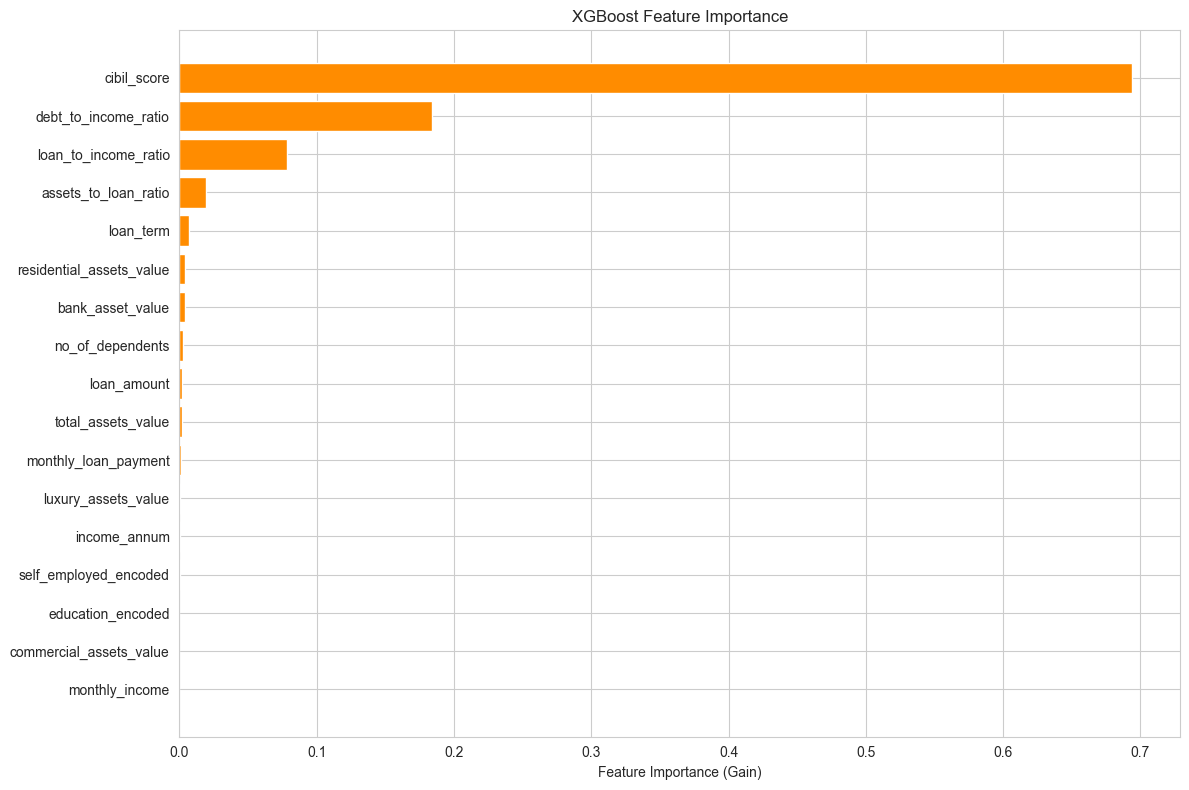


Top 5 Most Important Features (XGBoost):
                 Feature  Importance
4            cibil_score    0.694189
16  debt_to_income_ratio    0.184108
12  loan_to_income_ratio    0.078124
13  assets_to_loan_ratio    0.019254
3              loan_term    0.007056


In [29]:
# ============================================
# 8.2 XGBoost Feature Importance
# ============================================

# Get feature importance (by gain)
xgb_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': xgb.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.barh(range(len(xgb_importance)), xgb_importance['Importance'], color='darkorange')
plt.yticks(range(len(xgb_importance)), xgb_importance['Feature'])
plt.xlabel('Feature Importance (Gain)')
plt.title('XGBoost Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('presentation_images/xgb_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nTop 5 Most Important Features (XGBoost):")
print(xgb_importance.head())

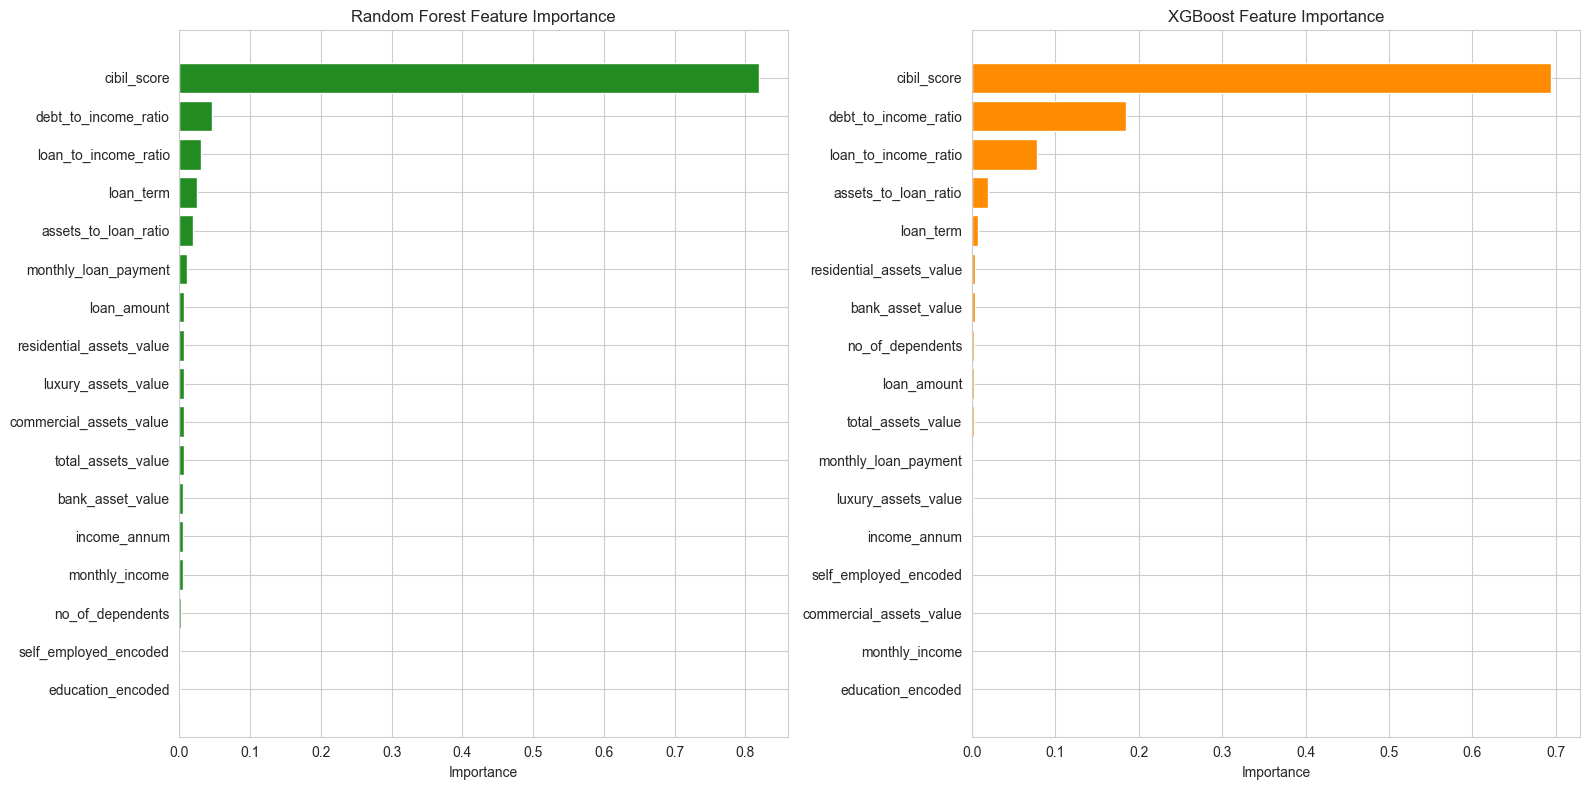

In [30]:
# ============================================
# 8.3 Compare RF and XGBoost Feature Importance
# ============================================

# Merge feature importance from both models
importance_comparison = rf_importance.merge(
    xgb_importance, on='Feature', suffixes=('_RF', '_XGB')
)

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Random Forest
rf_sorted = importance_comparison.sort_values('Importance_RF', ascending=True)
axes[0].barh(rf_sorted['Feature'], rf_sorted['Importance_RF'], color='forestgreen')
axes[0].set_xlabel('Importance')
axes[0].set_title('Random Forest Feature Importance')

# XGBoost
xgb_sorted = importance_comparison.sort_values('Importance_XGB', ascending=True)
axes[1].barh(xgb_sorted['Feature'], xgb_sorted['Importance_XGB'], color='darkorange')
axes[1].set_xlabel('Importance')
axes[1].set_title('XGBoost Feature Importance')

plt.tight_layout()
plt.savefig('presentation_images/feature_importance_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

---
## Section 9: Neural Network (MLP)

**Modern ML Technique #4**

Multi-Layer Perceptron (MLP) is a feedforward neural network that can learn complex non-linear patterns.

In [31]:
# ============================================
# 9.1 Build Neural Network Architecture
# ============================================

def build_nn_model(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Build model
nn_model = build_nn_model(X_train_scaled.shape[1])

# Display model summary
nn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,777 (14.75 KB)

 Trainable params: 3,777 (14.75 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# ============================================
# 9.2 Train Neural Network
# ============================================

# Calculate class weights for imbalanced data
class_weights = {
    0: 1.0,  # Approved
    1: scale_pos_weight  # Rejected
}

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
history = nn_model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weights,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7127 - loss: 0.4430 - val_accuracy: 0.8960 - val_loss: 0.3110
Epoch 2/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step - accuracy: 0.8745 - loss: 0.2229 - val_accuracy: 0.9531 - val_loss: 0.1526
Epoch 3/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - accuracy: 0.9045 - loss: 0.1642 - val_accuracy: 0.9531 - val_loss: 0.1221
Epoch 4/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step - accuracy: 0.9100 - loss: 0.1578 - val_accuracy: 0.9546 - val_loss: 0.1150
Epoch 5/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step - accuracy: 0.9129 - loss: 0.1442 - val_accuracy: 0.9561 - val_loss: 0.1033
Epoch 6/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step - accuracy: 0.9268 - loss: 0.1292 - val_accuracy: 0.9546 - val_loss: 0.0993
Epoch 7/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step - accuracy: 0.9275 - loss: 0.1283 - val_accuracy: 0.9590 - val_loss: 0.0965
Epoch 8/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step - accuracy: 0.9356 - loss: 0.1138 - val_accura

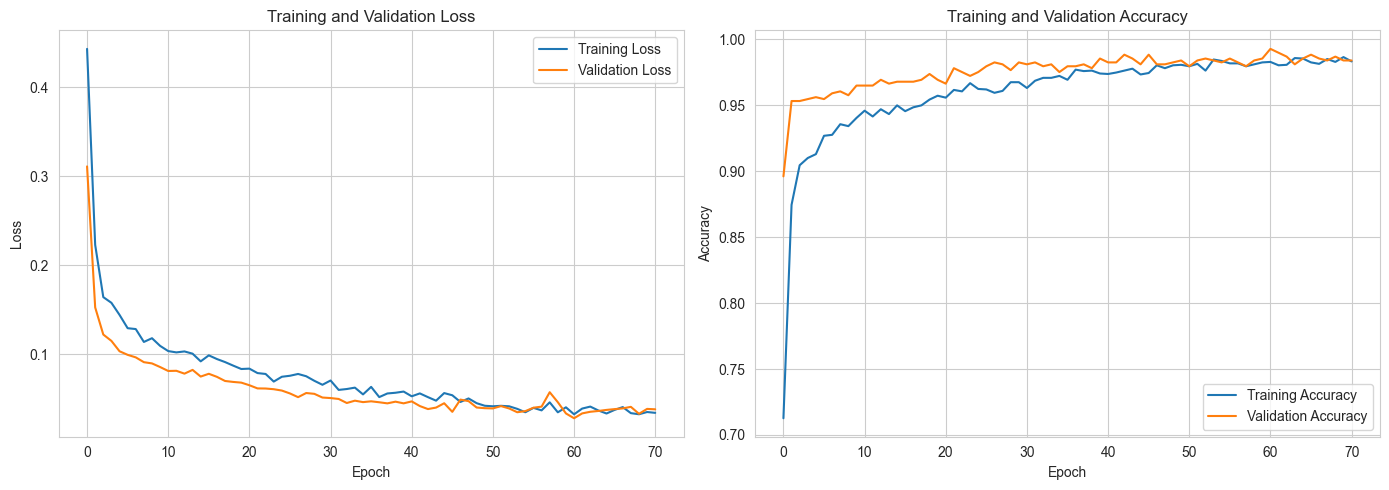

In [33]:
# ============================================
# 9.3 Visualize Training History
# ============================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()

# Accuracy
axes[1].plot(history.history['accuracy'], label='Training Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()

plt.tight_layout()
plt.savefig('presentation_images/nn_training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

In [34]:
# ============================================
# 9.4 Evaluate Neural Network
# ============================================

# Predictions
y_prob_nn = nn_model.predict(X_test_scaled).flatten()
y_pred_nn = (y_prob_nn > 0.5).astype(int)

# Evaluate
evaluate_model('Neural Network', y_test, y_pred_nn, y_prob_nn)

# Confusion Matrix
print(f"\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_nn))

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step

Neural Network Results
Accuracy:  0.9824
Precision: 0.9873
Recall:    0.9659
F1-Score:  0.9765
ROC-AUC:   0.9970

Confusion Matrix:
[[527   4]
 [ 11 312]]


---
## Section 10: Model Comparison

Compare all models across multiple metrics to identify the best performer.

In [35]:
# ============================================
# 10.1 Create Comparison Table
# ============================================

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
results_df = results_df.round(4)

# Sort by F1-Score (our primary metric for imbalanced data)
results_df = results_df.sort_values('F1-Score', ascending=False)

print("="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)
print(results_df.to_string())
print("\n" + "="*80)

MODEL COMPARISON SUMMARY
                                  Accuracy  Precision  Recall  F1-Score  ROC-AUC
Random Forest                       0.9988     1.0000  0.9969    0.9984   1.0000
Random Forest (Tuned)               0.9988     1.0000  0.9969    0.9984   1.0000
XGBoost                             0.9977     0.9969  0.9969    0.9969   1.0000
Neural Network                      0.9824     0.9873  0.9659    0.9765   0.9970
SVM (Tuned RBF)                     0.9578     0.9556  0.9319    0.9436   0.9913
SVM (RBF)                           0.9555     0.9385  0.9443    0.9414   0.9877
SVM (Linear)                        0.9485     0.9189  0.9474    0.9329   0.9779
SVM (Polynomial)                    0.9473     0.9162  0.9474    0.9315   0.9816
Logistic Regression (Baseline)      0.9450     0.9182  0.9381    0.9280   0.9778
Logistic Regression (L1)            0.9450     0.9182  0.9381    0.9280   0.9778
Logistic Regression (L2)            0.9450     0.9182  0.9381    0.9280   0.9778
Log

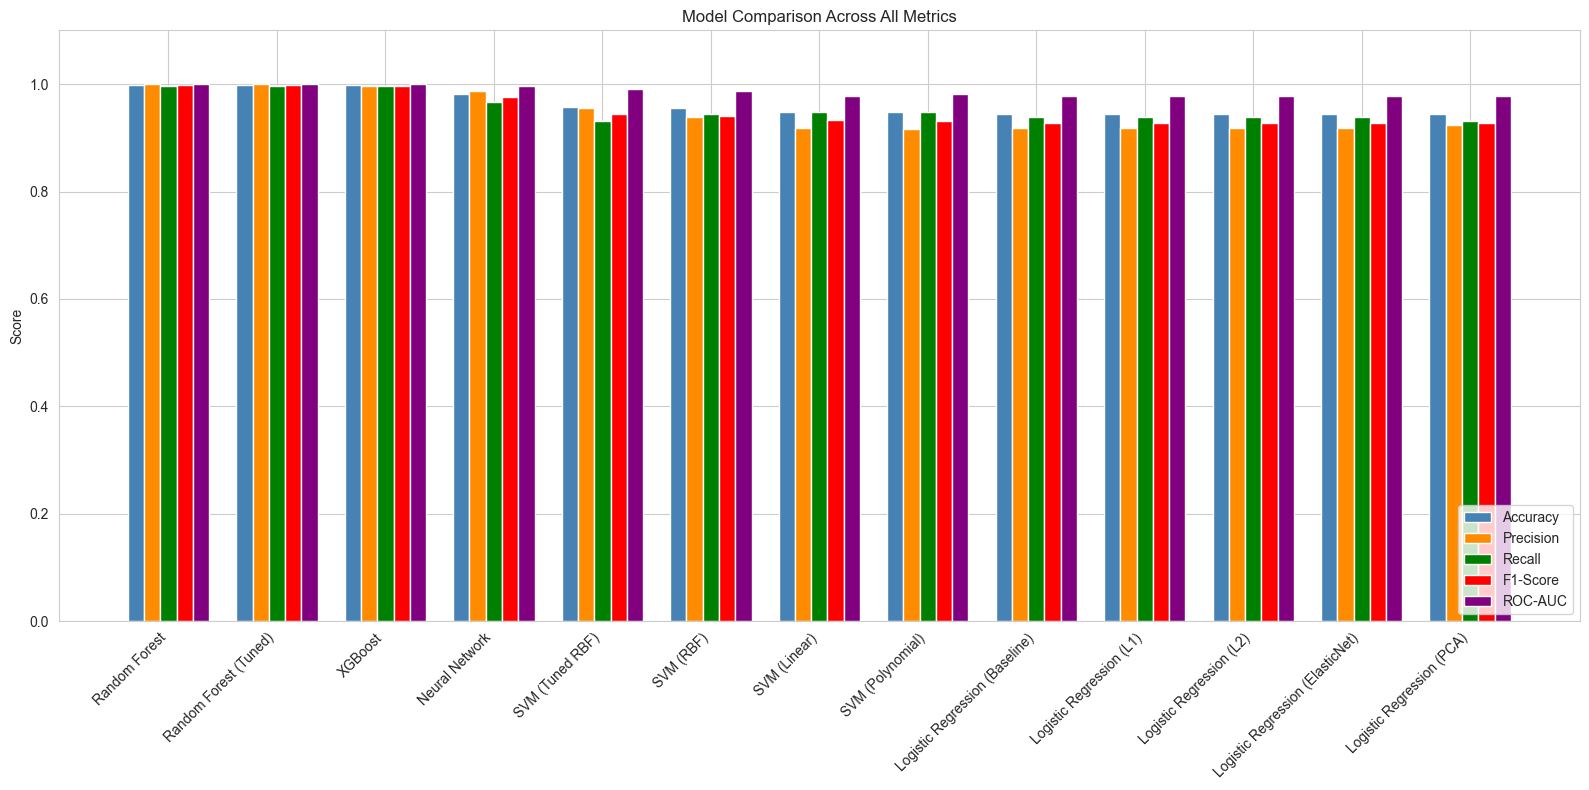

In [36]:
# ============================================
# 10.2 Visualize Model Comparison
# ============================================

# Prepare data for visualization
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
models = results_df.index.tolist()

# Create grouped bar chart
fig, ax = plt.subplots(figsize=(16, 8))

x = np.arange(len(models))
width = 0.15

colors = ['steelblue', 'darkorange', 'green', 'red', 'purple']

for i, metric in enumerate(metrics):
    values = results_df[metric].values
    ax.bar(x + i*width, values, width, label=metric, color=colors[i])

ax.set_ylabel('Score')
ax.set_title('Model Comparison Across All Metrics')
ax.set_xticks(x + width * 2)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend(loc='lower right')
ax.set_ylim(0, 1.1)

plt.tight_layout()
plt.savefig('presentation_images/model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

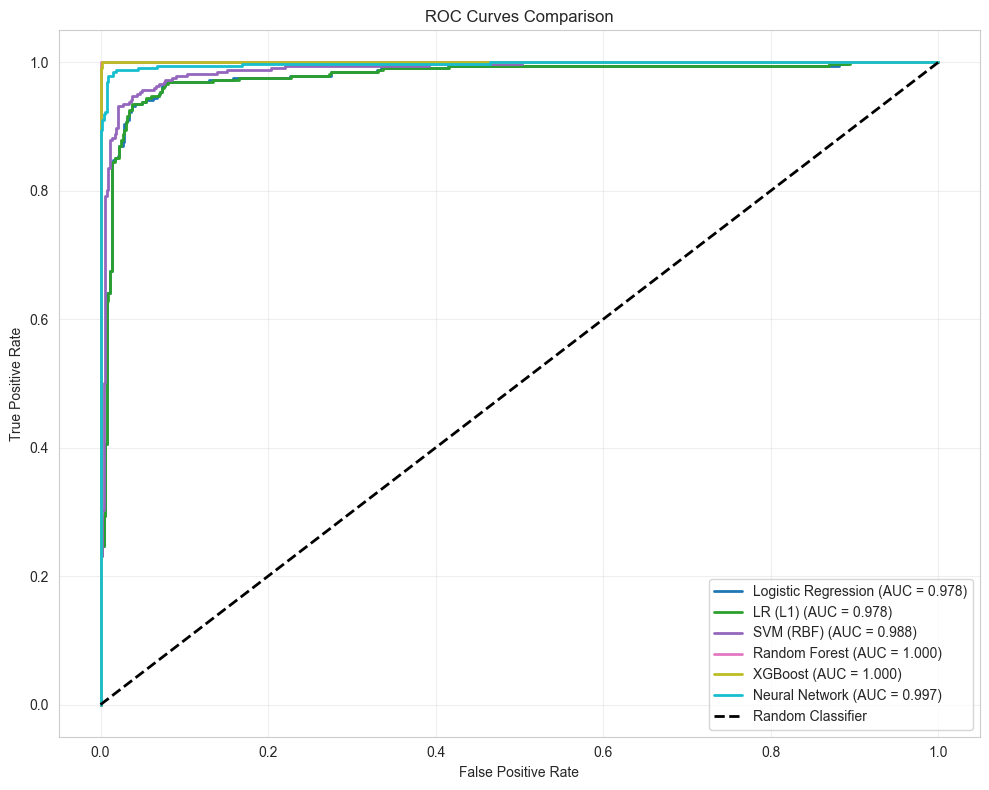

In [37]:
# ============================================
# 10.3 ROC Curves Comparison
# ============================================

plt.figure(figsize=(10, 8))

# Store predictions for ROC curves
roc_data = {
    'Logistic Regression': y_prob_lr,
    'LR (L1)': y_prob_l1,
    'SVM (RBF)': y_prob_svm_rbf,
    'Random Forest': y_prob_rf,
    'XGBoost': y_prob_xgb,
    'Neural Network': y_prob_nn
}

colors = plt.cm.tab10(np.linspace(0, 1, len(roc_data)))

for (name, y_prob), color in zip(roc_data.items(), colors):
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, color=color, lw=2, label=f'{name} (AUC = {auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('presentation_images/roc_curves_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

In [38]:
# ============================================
# 10.4 Best Model Identification
# ============================================

# Find best model by F1-Score
best_model = results_df['F1-Score'].idxmax()
best_f1 = results_df.loc[best_model, 'F1-Score']

# Find best model by ROC-AUC
best_model_auc = results_df['ROC-AUC'].idxmax()
best_auc = results_df.loc[best_model_auc, 'ROC-AUC']

print("="*60)
print("BEST MODEL IDENTIFICATION")
print("="*60)
print(f"\nBest Model by F1-Score: {best_model}")
print(f"  F1-Score: {best_f1:.4f}")
print(f"\nBest Model by ROC-AUC: {best_model_auc}")
print(f"  ROC-AUC: {best_auc:.4f}")
print("\n" + "="*60)

BEST MODEL IDENTIFICATION

Best Model by F1-Score: Random Forest
  F1-Score: 0.9984

Best Model by ROC-AUC: Random Forest
  ROC-AUC: 1.0000



---
## Section 11: Feature Importance Analysis

Aggregate feature importance from multiple models to identify the most influential predictors.

In [39]:
# ============================================
# 11.1 Aggregate Feature Importance
# ============================================

# Normalize coefficients from Logistic Regression
lr_coef_normalized = np.abs(lr_baseline.coef_[0]) / np.abs(lr_baseline.coef_[0]).sum()

# Create aggregate importance DataFrame
aggregate_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Logistic_Regression': lr_coef_normalized,
    'Random_Forest': rf.feature_importances_,
    'XGBoost': xgb.feature_importances_
})

# Calculate average importance
aggregate_importance['Average'] = aggregate_importance[['Logistic_Regression', 'Random_Forest', 'XGBoost']].mean(axis=1)
aggregate_importance = aggregate_importance.sort_values('Average', ascending=False)

print("Aggregate Feature Importance (Top 10):")
print(aggregate_importance.head(10).to_string(index=False))

Aggregate Feature Importance (Top 10):
             Feature  Logistic_Regression  Random_Forest  XGBoost  Average
         cibil_score             0.494401       0.818677 0.694189 0.669089
debt_to_income_ratio             0.219276       0.046531 0.184108 0.149972
loan_to_income_ratio             0.026183       0.029908 0.078124 0.044738
           loan_term             0.052538       0.024296 0.007056 0.027963
monthly_loan_payment             0.038007       0.011303 0.001167 0.016826
assets_to_loan_ratio             0.006946       0.018852 0.019254 0.015017
 luxury_assets_value             0.031240       0.006188 0.000638 0.012689
        income_annum             0.030714       0.004935 0.000590 0.012080
      monthly_income             0.030714       0.004545 0.000000 0.011753
         loan_amount             0.022058       0.006641 0.002187 0.010295


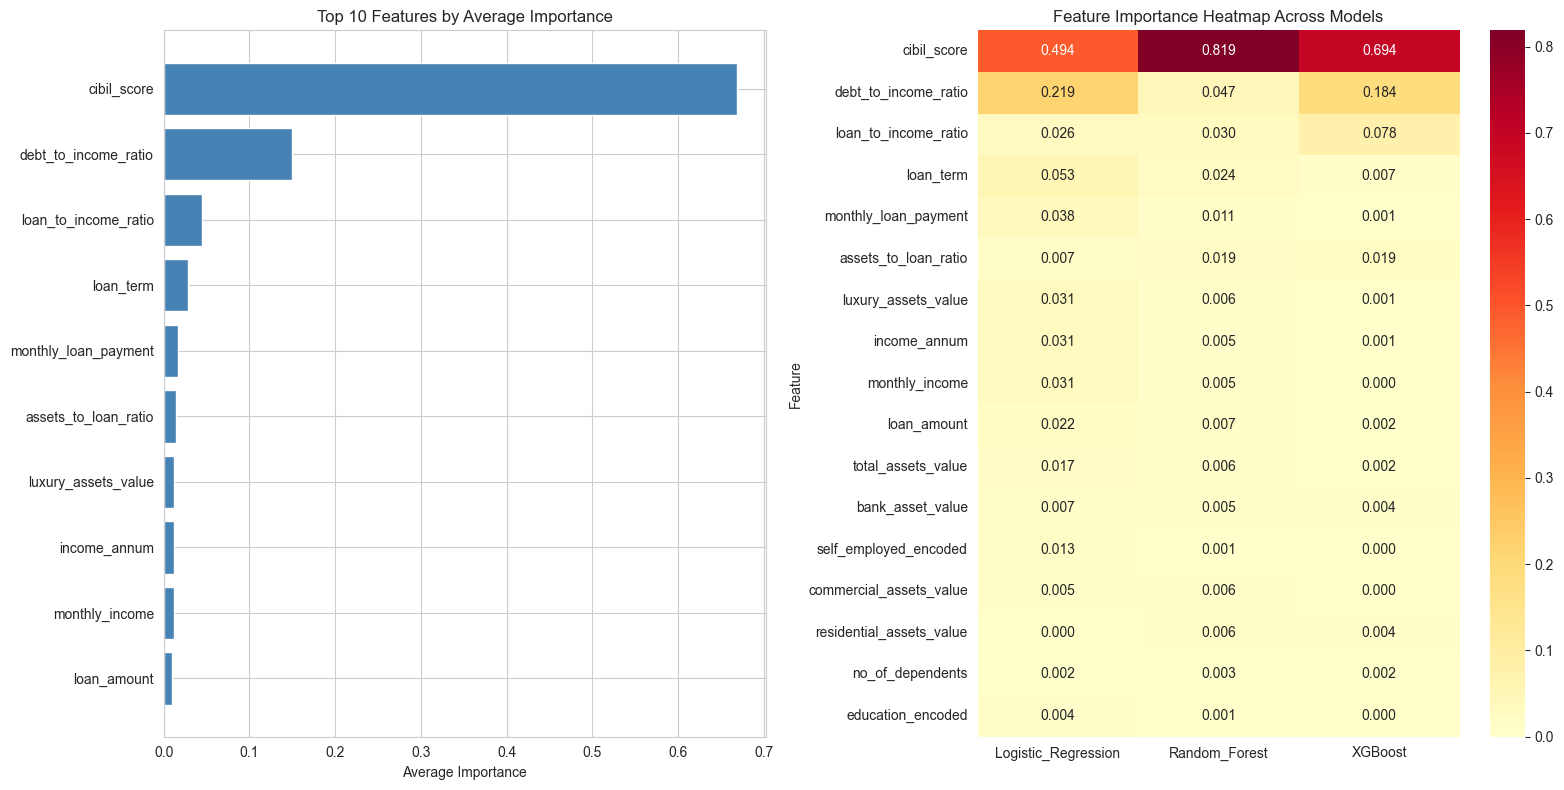

In [40]:
# ============================================
# 11.2 Visualize Aggregate Feature Importance
# ============================================

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Top 10 features by average importance
top_features = aggregate_importance.head(10)

# Bar chart of average importance
axes[0].barh(range(len(top_features)), top_features['Average'], color='steelblue')
axes[0].set_yticks(range(len(top_features)))
axes[0].set_yticklabels(top_features['Feature'])
axes[0].set_xlabel('Average Importance')
axes[0].set_title('Top 10 Features by Average Importance')
axes[0].invert_yaxis()

# Heatmap of importance across models
heatmap_data = aggregate_importance.set_index('Feature')[['Logistic_Regression', 'Random_Forest', 'XGBoost']]
sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='YlOrRd', ax=axes[1])
axes[1].set_title('Feature Importance Heatmap Across Models')

plt.tight_layout()
plt.savefig('presentation_images/aggregate_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

In [41]:
# ============================================
# 11.3 Top 5 Predictors with Business Interpretation
# ============================================

print("="*70)
print("TOP 5 PREDICTORS OF LOAN APPROVAL")
print("="*70)

top_5 = aggregate_importance.head(5)

interpretations = {
    'cibil_score': 'Credit score is the strongest indicator of creditworthiness',
    'loan_to_income_ratio': 'Higher ratio indicates higher loan burden relative to income',
    'debt_to_income_ratio': 'Critical financial health indicator',
    'assets_to_loan_ratio': 'Measures collateral coverage for the loan',
    'income_annum': 'Higher income increases ability to repay',
    'total_assets_value': 'Total assets provide financial security',
    'loan_amount': 'Larger loans carry higher risk',
    'monthly_loan_payment': 'Higher payments strain monthly budget',
    'monthly_income': 'Regular income ensures repayment capacity',
    'loan_term': 'Longer terms affect total interest paid'
}

for i, (_, row) in enumerate(top_5.iterrows(), 1):
    feature = row['Feature']
    avg_importance = row['Average']
    interpretation = interpretations.get(feature, 'Important predictor of loan approval')
    
    print(f"\n{i}. {feature}")
    print(f"   Average Importance: {avg_importance:.4f}")
    print(f"   Interpretation: {interpretation}")

print("\n" + "="*70)

TOP 5 PREDICTORS OF LOAN APPROVAL

1. cibil_score
   Average Importance: 0.6691
   Interpretation: Credit score is the strongest indicator of creditworthiness

2. debt_to_income_ratio
   Average Importance: 0.1500
   Interpretation: Critical financial health indicator

3. loan_to_income_ratio
   Average Importance: 0.0447
   Interpretation: Higher ratio indicates higher loan burden relative to income

4. loan_term
   Average Importance: 0.0280
   Interpretation: Longer terms affect total interest paid

5. monthly_loan_payment
   Average Importance: 0.0168
   Interpretation: Higher payments strain monthly budget



---
## Section 12: Conclusions

Summary of findings and recommendations.

In [42]:
# ============================================
# 12.1 Final Summary
# ============================================

print("="*70)
print("STEP 3: MODEL DEVELOPMENT - FINAL SUMMARY")
print("="*70)

print("\n📊 DATASET OVERVIEW")
print("-"*40)
print(f"Total Samples: 4,269")
print(f"Features Used: 17")
print(f"Class Distribution: 62% Rejected, 38% Approved")
print(f"Train/Test Split: 80/20 (Stratified)")

print("\n🔧 CLASSICAL ML TECHNIQUES")
print("-"*40)
print("✓ Logistic Regression (Baseline)")
print("✓ Regularization (L1/L2/ElasticNet)")
print("✓ Principal Component Analysis (PCA)")
print("✓ Cross-Validation (5-Fold Stratified)")

print("\n🚀 MODERN ML TECHNIQUES")
print("-"*40)
print("✓ Support Vector Machines (Linear, RBF, Polynomial)")
print("✓ Random Forest Classifier")
print("✓ XGBoost (Gradient Boosting)")
print("✓ Neural Network (MLP)")

print("\n🏆 BEST MODEL")
print("-"*40)
print(f"Model: {best_model}")
print(f"F1-Score: {best_f1:.4f}")
print(f"ROC-AUC: {results_df.loc[best_model, 'ROC-AUC']:.4f}")

print("\n📈 TOP 5 PREDICTORS")
print("-"*40)
for i, (_, row) in enumerate(aggregate_importance.head(5).iterrows(), 1):
    print(f"{i}. {row['Feature']} (Importance: {row['Average']:.4f})")

print("\n💡 KEY FINDINGS")
print("-"*40)
print("1. CIBIL score is the most important predictor of loan approval")
print("2. Financial ratios (debt-to-income, loan-to-income) are critical")
print("3. Modern ML techniques (RF, XGBoost) outperform classical methods")
print("4. Class imbalance was effectively handled with balanced weights")
print("5. Feature engineering improved model interpretability")

print("\n" + "="*70)

STEP 3: MODEL DEVELOPMENT - FINAL SUMMARY

📊 DATASET OVERVIEW
----------------------------------------
Total Samples: 4,269
Features Used: 17
Class Distribution: 62% Rejected, 38% Approved
Train/Test Split: 80/20 (Stratified)

🔧 CLASSICAL ML TECHNIQUES
----------------------------------------
✓ Logistic Regression (Baseline)
✓ Regularization (L1/L2/ElasticNet)
✓ Principal Component Analysis (PCA)
✓ Cross-Validation (5-Fold Stratified)

🚀 MODERN ML TECHNIQUES
----------------------------------------
✓ Support Vector Machines (Linear, RBF, Polynomial)
✓ Random Forest Classifier
✓ XGBoost (Gradient Boosting)
✓ Neural Network (MLP)

🏆 BEST MODEL
----------------------------------------
Model: Random Forest
F1-Score: 0.9984
ROC-AUC: 1.0000

📈 TOP 5 PREDICTORS
----------------------------------------
1. cibil_score (Importance: 0.6691)
2. debt_to_income_ratio (Importance: 0.1500)
3. loan_to_income_ratio (Importance: 0.0447)
4. loan_term (Importance: 0.0280)
5. monthly_loan_payment (Importanc

In [43]:
# ============================================
# 12.2 Save Final Results
# ============================================

# Save results to CSV
results_df.to_csv('data/model_results.csv')
aggregate_importance.to_csv('data/feature_importance.csv', index=False)

print("Results saved to:")
print("  - data/model_results.csv")
print("  - data/feature_importance.csv")
print("\nVisualization images saved to presentation_images/ folder:")
print("  - lr_coefficients.png")
print("  - regularization_comparison.png")
print("  - pca_variance.png")
print("  - cv_results_classical.png")
print("  - rf_feature_importance.png")
print("  - xgb_feature_importance.png")
print("  - feature_importance_comparison.png")
print("  - nn_training_curves.png")
print("  - model_comparison.png")
print("  - roc_curves_comparison.png")
print("  - aggregate_feature_importance.png")

Results saved to:
  - data/model_results.csv
  - data/feature_importance.csv

Visualization images saved to presentation_images/ folder:
  - lr_coefficients.png
  - regularization_comparison.png
  - pca_variance.png
  - cv_results_classical.png
  - rf_feature_importance.png
  - xgb_feature_importance.png
  - feature_importance_comparison.png
  - nn_training_curves.png
  - model_comparison.png
  - roc_curves_comparison.png
  - aggregate_feature_importance.png


In [44]:
# ============================================
# 12.3 Classical vs Modern ML Comparison
# ============================================

# Categorize models
classical_models = ['Logistic Regression (Baseline)', 'Logistic Regression (L1)', 
                    'Logistic Regression (L2)', 'Logistic Regression (ElasticNet)', 
                    'Logistic Regression (PCA)']
modern_models = ['SVM (Linear)', 'SVM (RBF)', 'SVM (Polynomial)', 'SVM (Tuned RBF)',
                 'Random Forest', 'Random Forest (Tuned)', 'XGBoost', 'Neural Network']

# Calculate average metrics for each category
classical_results = results_df[results_df.index.isin(classical_models)]
modern_results = results_df[results_df.index.isin(modern_models)]

print("="*60)
print("CLASSICAL vs MODERN ML COMPARISON")
print("="*60)

if len(classical_results) > 0:
    print(f"\nClassical ML (avg of {len(classical_results)} models):")
    print(f"  Accuracy:  {classical_results['Accuracy'].mean():.4f}")
    print(f"  F1-Score:  {classical_results['F1-Score'].mean():.4f}")
    print(f"  ROC-AUC:   {classical_results['ROC-AUC'].mean():.4f}")

if len(modern_results) > 0:
    print(f"\nModern ML (avg of {len(modern_results)} models):")
    print(f"  Accuracy:  {modern_results['Accuracy'].mean():.4f}")
    print(f"  F1-Score:  {modern_results['F1-Score'].mean():.4f}")
    print(f"  ROC-AUC:   {modern_results['ROC-AUC'].mean():.4f}")

print("\n" + "="*60)
print("\nREADY FOR STEP 4: EVALUATION & ANALYSIS")
print("="*60)

CLASSICAL vs MODERN ML COMPARISON

Classical ML (avg of 5 models):
  Accuracy:  0.9450
  F1-Score:  0.9279
  ROC-AUC:   0.9778

Modern ML (avg of 8 models):
  Accuracy:  0.9734
  F1-Score:  0.9649
  ROC-AUC:   0.9919


READY FOR STEP 4: EVALUATION & ANALYSIS


---
## Summary for Presentation

### Key Slides to Create:

1. **Model Development Overview** - Techniques applied
2. **Data Preparation** - 17 features, 80/20 split, scaling
3. **Logistic Regression** - Baseline results + coefficients
4. **Regularization** - L1/L2/ElasticNet comparison
5. **PCA Analysis** - Variance explained + performance
6. **Cross-Validation** - 5-Fold results chart
7. **SVM Results** - Kernel comparison
8. **Random Forest** - Results + feature importance
9. **XGBoost** - Results + feature importance
10. **Neural Network** - Architecture + training curves
11. **Model Comparison** - Summary table + ROC curves
12. **Feature Importance** - Top predictors
13. **Conclusions** - Best model + key findings

### Images Generated:
All visualization images are saved in `presentation_images/` folder and ready for use in your presentation.